<H1>  Applied Data Science Capstone </H1>
<H2> <i> Applied Data Science Capstone </i> </H2>
<H3> <i> El Mehdi Benammi </i> </H3>


<H1>  INTRODUCTION </H1>

<p style="text-align:justified;">A hypothetic investor wants to analyze the current market situation of food shops and coffee shops in the city of Casablanca. The reason why his choice isn’t clear, is because the city is known as the economic capitol of Morocco. It’s a melting pot of multiple types of activities and is described by a rich diversity in termed of nationalities and their respective ethnicities (some kind of alpha version of New York). Because of this diverse characteristic, food venues are also diverse and are strictly not limited to one type. They span from Famous Fast-Food brands, to dinners and small food shops. </p>

<p style="text-align:justified;">For the restaurant category, each can be available with a specific type of cuisine (Italian, French, Spanish…), which also make things more complicated. As for coffees, even if their type of diversity isn’t an issue, the decision on opening a coffee shop or a restaurant is also a relevant problem for the investor.
    
Another big issue is related to the location of these venues. Where in the city should he make his project happen? This location problem is an important one since it could impact directly the success of venue. 
    
Our hypothetic investor has money but doesn’t have the time neither the necessary tools to analyze the data and to make the right decision. For this reason, it was proposed to extract data from the Foursquare’s API. These contains information about the geographical location, the type of venue, their names and their related likes.
    
Within our current work, our main objective knowing the problem, is to make recommendation based on the Foursquare’s API about these tree aspects:</p>

<li>Location analysis</li>
<li>Analysis of the trending category of venue (fast-food, restaurant, cafe…)</li>
<li>Analysis of the type of cuisine  if restaurants are chosen (French, spinach, Japanese…)</li>

<p style="text-align:justified;">These different aspects can be studied based on the “likes” that are provided by the API. An analysis will be conducted to evaluate the overall usability of this data to optimize the decision on these issues.</p>

<H1>LIBRARIES AND TOOLS</H1>

In [4]:
!pip install geocoder
!pip install folium
!pip install geopy

In [5]:
import folium
import requests
import pandas as pd
import numpy as np
import geocoder
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
sns.set_style('darkgrid')


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score


<H1>  2 DATA </H1>

<H2> <i> 2.1 DATA IMPORTING (SCRAPING) </i> </H2>


<p style="text-align:justified;">The first part that will be discussed about data is related to their importation. We will use Foursquare API. For this purpose, the credentials obtained from Foursquare developer site were used to extract the data using the spatial URL for requests. 

The data importation focused on this information: </p>

<li>Venue Name</li>
<li>Latitude and longitude</li>
<li>Venue id</li>
<li>Venue category (type);</li>
<li>Likes based on their id</li>

<p style="text-align:justified;">The link also contains the geolocation of our targeted city. By using geocode we managed to get the longitude and latitude of CASABLANCA (Morocco). After inserting the information, the request was conducted and the relevant data was obtained. A maximum number of venues of 100 and in a radius of 1000, Km were specified within the limit’s values of the API. After importation, the data were saved within a Pandas data frame.</p>

<H3> <i> 2.1.1 ADRESS FETCHING OF THE CITY </i> </H3>

In [6]:

address = 'Ain diab, casablanca, Morocco'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of agdal are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of agdal are 33.5888533, -7.6740072.


<H3> <i> 2.1.2 CLIENT ID AND URL CONSTRUCT </i> </H3>

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value
radius = 10000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()



<H3> <i> 2.1.3 INITIAL TABLE CREATION FROM THE IMPORT RESULT AND ADDING OF LIKES </i> </H3>

In [8]:
#FUNCTION TO GET CATEGORIES

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#EXECUTION OF THE FUNCITON 

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.shape

#LIKES FETCHING


url_list = []
like_list = []
json_list = []

for idx, venue in enumerate(list(nearby_venues.id)):
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)


for idx, link in enumerate(url_list):
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)

nearby_venues['likes']=like_list
nearby_venues.drop(columns='id',inplace=True)


D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


<H3> <i> 2.1.4 OBTAINED TABLE FOR STUDY </i> </H3>

In [9]:
nearby_venues

,name,categories,lat,lng,likes
0,Basmane Restaurant,Moroccan Restaurant,33.591577,-7.677553,108
1,Royal Golf D'Anfa,Golf Course,33.588384,-7.658432,30
2,Relais de Paris,French Restaurant,33.601338,-7.660414,76
3,Starbucks,Coffee Shop,33.589764,-7.649899,147
4,Four Seasons Hotel Casablanca,Hotel,33.599630,-7.663815,123
...,...,...,...,...,...
95,Amoud Belvédère,Bakery,33.593819,-7.596258,22
96,Cityfoot,Soccer Stadium,33.550070,-7.636074,24
97,Anciens Abattoirs De Casablanca,Performing Arts Venue,33.594136,-7.581700,32
98,AYOUR,Fast Food Restaurant,33.570383,-7.609602,27


<H2> <i> 2.2 DATA CLEANING</i> </H2>

<p style="text-align:justified;">The first preview of data showed that we have 100 rows and 5 columns related to the imported information, without the ID of each venue. No nan values were detected and both longitude and latitude were imported as floats.</p>

<p style="text-align:justified;">We do know that foursquare API was used to import values for venues within a big radius. So having some irrelevant type of results was accounted from the start. For this purpose, we proceeded by showing the unique groups of venues that were imported.
    
This step helped to pin point the name of groups that should be dropped from the list, as they are not linked to either food venues or coffee shops.
    
Another aspect that was clear afterwards is the existence of redundant names. For example, “coffee shops” and “Café” were both used even though they both related to the same type of venues.
</p>

<H3> <i> 2.2.1 DATA CLEANING: SHAPE AND DTYPE ANALYSIS</i> </H3>

In [10]:
nearby_venues.shape

(100, 5)

In [11]:
nearby_venues.dtypes

name           object
categories     object
lat           float64
lng           float64
likes           int64
dtype: object

<H3> <i> 2.2.2 DATA CLEANING: CATEGORIES CLEANING FROM IRRELEVENT ENTIRES</i> </H3>

In [12]:
nearby_venues['categories'].unique()

array(['Moroccan Restaurant', 'Golf Course', 'French Restaurant',
       'Coffee Shop', 'Hotel', 'Harbor / Marina', 'Beach', 'Steakhouse',
       'Lighthouse', 'Café', 'Lounge', 'Bakery', 'Ice Cream Shop',
       'Shopping Mall', 'Dessert Shop', 'Italian Restaurant',
       'Japanese Restaurant', 'Asian Restaurant', 'Indian Restaurant',
       'Cupcake Shop', 'Pizza Place', 'Movie Theater', 'Burger Joint',
       'Boutique', 'Juice Bar', 'Gastropub', 'Latin American Restaurant',
       'Vegetarian / Vegan Restaurant', 'Turkish Restaurant', 'Diner',
       'Salad Place', 'Art Gallery', 'Library', 'Tapas Restaurant', 'Pub',
       'Sandwich Place', 'Clothing Store', 'Electronics Store',
       'Seafood Restaurant', 'Plaza', 'Neighborhood', 'Restaurant',
       'Park', 'Spa', 'History Museum', 'Sushi Restaurant',
       'Soccer Stadium', 'Performing Arts Venue', 'Fast Food Restaurant'],
      dtype=object)

In [13]:
categories_to_drop=["Bar","Beer Garden","Cocktail Bar", "Hotel", """Men's Store""","Train Station","Pool Hall", "Pool","Nightclub","Forest","Park","Bus Station","Light Rail Station","Tennis Stadium","Gourmet Shop","Library","Plaza","Golf Course",
                   "Beach","Harbor / Marina","Electronics Store","Spa","Soccer Stadium","Performing Arts Venue","History Museum","Neighborhood","Art Gallery","Clothing Store","Shopping Mall","Lighthouse","Movie Theater","Boutique"]
filtred_venues=nearby_venues[~nearby_venues['categories'].isin(categories_to_drop)]

In [14]:
filtred_venues['categories'].unique()

array(['Moroccan Restaurant', 'French Restaurant', 'Coffee Shop',
       'Steakhouse', 'Café', 'Lounge', 'Bakery', 'Ice Cream Shop',
       'Dessert Shop', 'Italian Restaurant', 'Japanese Restaurant',
       'Asian Restaurant', 'Indian Restaurant', 'Cupcake Shop',
       'Pizza Place', 'Burger Joint', 'Juice Bar', 'Gastropub',
       'Latin American Restaurant', 'Vegetarian / Vegan Restaurant',
       'Turkish Restaurant', 'Diner', 'Salad Place', 'Tapas Restaurant',
       'Pub', 'Sandwich Place', 'Seafood Restaurant', 'Restaurant',
       'Sushi Restaurant', 'Fast Food Restaurant'], dtype=object)

<H3> <i> 2.2.3 DATA CLEANING: MERGING OF REDUNDANT ENTIRES</i> </H3>

In [15]:
filtred_venues['categories_merged']=filtred_venues['categories']

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:

pattern_rest = '|'.join(['Coffee Shop','Café'])


filtred_venues.loc[filtred_venues['categories'].str.contains(pattern_rest, case=False),'categories_merged']='Cafe'
filtred_venues.drop([54], axis=0,inplace=True)

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
filtred_venues['categories_merged'].unique()


array(['Moroccan Restaurant', 'French Restaurant', 'Cafe', 'Steakhouse',
       'Lounge', 'Bakery', 'Ice Cream Shop', 'Dessert Shop',
       'Italian Restaurant', 'Japanese Restaurant', 'Asian Restaurant',
       'Indian Restaurant', 'Cupcake Shop', 'Pizza Place', 'Burger Joint',
       'Juice Bar', 'Gastropub', 'Latin American Restaurant',
       'Vegetarian / Vegan Restaurant', 'Turkish Restaurant', 'Diner',
       'Salad Place', 'Tapas Restaurant', 'Pub', 'Sandwich Place',
       'Seafood Restaurant', 'Restaurant', 'Sushi Restaurant',
       'Fast Food Restaurant'], dtype=object)

In [18]:
filtred_venues

,name,categories,lat,lng,likes,categories_merged
0,Basmane Restaurant,Moroccan Restaurant,33.591577,-7.677553,108,Moroccan Restaurant
2,Relais de Paris,French Restaurant,33.601338,-7.660414,76,French Restaurant
3,Starbucks,Coffee Shop,33.589764,-7.649899,147,Cafe
8,Oncle Blend,Steakhouse,33.592861,-7.644154,54,Steakhouse
10,Le Marly,Café,33.588329,-7.644954,42,Cafe
...,...,...,...,...,...,...
93,salon de thé et restaurant Manar dar Salame,Moroccan Restaurant,33.561970,-7.616498,8,Moroccan Restaurant
94,Iceberry,Ice Cream Shop,33.575341,-7.707529,6,Ice Cream Shop
95,Amoud Belvédère,Bakery,33.593819,-7.596258,22,Bakery
98,AYOUR,Fast Food Restaurant,33.570383,-7.609602,27,Fast Food Restaurant


<H2> <i> 2.3 DATA PREPARATION</i> </H2>


<p style="text-align:justified;">After combining the redundant grouped names and merging the ones that basically the same thing in term of food, we continued our task by creating a convenable grouping scheme to specify the main categories of venues:</p>


<p>
<li>Restaurants</li>
<li>Café</li>
<li>Dessert and refreshment</li>
<li>Beer and food</li>
<li>Fast food</li>
<li>Bakery</li>    
</p>

<p style="text-align:justified;">This process was done by specifying keywords that should be searched for to fill in the correct group value in a new column. At the end of this step, we managed to get a binned column that can be exploited for the analysis and choice of the relevant category.
    
The second step concerned the type of cuisine. Since the imported categories from the foursquare API contains relevant keywords of their cuisine, it was clear that would should proceed by generating a value linked to the type of cuisine, based on the correct detection of the type in the imported data. When no specified value is detected, and the venue is still classified as restaurant, a “General” value is pushed in the type of cuisine. We assume by that, that the venue proposes multiple types of foods and because of that, no type of cuisine could be defined from the start.

The likes that are provided should be also binned for the purpose of the study. This process was done by leveraging the qcut method of pandas, that uses the quantiles as limits and cut the data to provide us with bins. These categories of likes can be used later on.

</p>

<H3> <i> 2.3.1 DATA PREPARATION : JOINING GROUPES</i> </H3>

In [19]:
#creating column to work on

filtred_venues['groupes_venues']=filtred_venues['categories_merged']


#joining dessert places

pattern_dessert = '|'.join(['Ice Cream Shop','Dessert Shop','Juice Bar'])

filtred_venues.loc[filtred_venues['categories_merged'].str.contains(pattern_dessert, case=False),'groupes_venues']='Dessert and refreshment'


#joining restaurants

pattern_restaurant = '|'.join(['Restaurant','Diner','Steakhouse'])

filtred_venues.loc[filtred_venues['categories_merged'].str.contains(pattern_restaurant, case=False),'groupes_venues']='Restaurants'


#joining beer and food places

pattern_beerfood = '|'.join(['Gastropub','Pub','Lounge'])

filtred_venues.loc[filtred_venues['categories_merged'].str.contains(pattern_beerfood, case=False),'groupes_venues']='Beer and food'

#joining bakeries


pattern_bakery = '|'.join(['Bakery','Cupcake Shop'])

filtred_venues.loc[filtred_venues['categories_merged'].str.contains(pattern_bakery, case=False),'groupes_venues']='Bakery'

#joining fastfood


pattern_fastfood = '|'.join(['Pizza','Chicken','Burger','Sandwich','Salad','Fast Food'])

filtred_venues.loc[filtred_venues['categories_merged'].str.contains(pattern_fastfood, case=False),'groupes_venues']='Fast Food'



filtred_venues['groupes_venues'].unique()

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


array(['Restaurants', 'Cafe', 'Beer and food', 'Bakery',
       'Dessert and refreshment', 'Fast Food'], dtype=object)

<H3> <i> 2.3.2 DATA PREPARATION : BINNING LIKES BY QUANTILES</i> </H3>

In [20]:
binlabels=[1,2,3,4,5]
filtred_venues['binnedlikes']=pd.qcut(filtred_venues['likes'],q=5, labels=binlabels)

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<H3> <i> 2.3.3 DATA PREPARATION : CLASSIFYING TYPE OF CUISINE FOR RESTAURANTS</i> </H3>

In [21]:
#creating table specific to restaurants

filtred_venues_restaurants=filtred_venues[filtred_venues['groupes_venues']=='Restaurants']

#function to classify by type

def categorize_restaurants(table):
    if table['categories_merged'] in ['Moroccan Restaurant']:
        return 'Moroccan'
    if table['categories_merged'] in ['Italian Restaurant','Pizza Place']:
        return 'Italian'
    if table['categories_merged'] in ['Japanese Restaurant','Asian Restaurant','Sushi Restaurant']:
        return 'Asian'    
    if table['categories_merged'] in ['Seafood Restaurant']:
        return 'Seafood'
    if table['categories_merged'] in ['Vegetarian / Vegan Restaurant']:
        return 'Vegan'    
    if table['categories_merged'] in ['Indian Restaurant']:
        return 'Indian'        
    if table['categories_merged'] in ['Turkish Restaurant']:
        return 'Turkish'   
    if table['categories_merged'] in ['Latin American Restaurant']:
        return 'Latino'   
    if table['categories_merged'] in ['Diner','Steakhouse']:
        return 'American'   
    if table['categories_merged'] in ['French Restaurant']:
        return 'French'           
    if table['categories_merged'] in ['Tapas Restaurant']:
        return 'Spanish'          
    if table['categories_merged'] in ['Restaurant']:
        return 'General'        
        
#Application of the function and creation of a type of cuisine column for restaurants only

filtred_venues_restaurants['types_cuisine']= filtred_venues.apply(categorize_restaurants, axis=1)
filtred_venues_restaurants

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,name,categories,lat,lng,likes,categories_merged,groupes_venues,binnedlikes,types_cuisine
0,Basmane Restaurant,Moroccan Restaurant,33.591577,-7.677553,108,Moroccan Restaurant,Restaurants,5,Moroccan
2,Relais de Paris,French Restaurant,33.601338,-7.660414,76,French Restaurant,Restaurants,4,French
8,Oncle Blend,Steakhouse,33.592861,-7.644154,54,Steakhouse,Restaurants,4,American
23,Boccaccio,Italian Restaurant,33.590657,-7.638359,9,Italian Restaurant,Restaurants,1,Italian
24,Iloli,Japanese Restaurant,33.590694,-7.634412,39,Japanese Restaurant,Restaurants,3,Asian
...,...,...,...,...,...,...,...,...,...
82,Ifrane,Restaurant,33.592619,-7.617246,14,Restaurant,Restaurants,1,General
87,pasta d'oro,Italian Restaurant,33.535864,-7.640950,8,Italian Restaurant,Restaurants,1,Italian
91,Yoka Sushi,Sushi Restaurant,33.535129,-7.639541,21,Sushi Restaurant,Restaurants,2,Asian
93,salon de thé et restaurant Manar dar Salame,Moroccan Restaurant,33.561970,-7.616498,8,Moroccan Restaurant,Restaurants,1,Moroccan


<H2> <i> 2.2 DATA VISUALISATION </i> </H2>

<H3> <i> 2.2.1 DATA VISUALISATION : STATISTICAL ANALYSIS OF GROUPED TYPES OF VENUES BY COUNT </i> </H3>


<p style="text-align:justified;"></p>

<p style="text-align:justified;">The first visualisation step that was followed was checking the absolute count of each groupe of venues and to assess which one is dominant. We can already see that restaurants are priming in term of number. The main result obtained by this step is that restaurants are the most present, followed by cafe venues

</p>

In [22]:
filtred_venues.groupby(by='groupes_venues', as_index=False).count().iloc[:,:2]

,groupes_venues,name
0,Bakery,6
1,Beer and food,6
2,Cafe,19
3,Dessert and refreshment,9
4,Fast Food,6
5,Restaurants,25


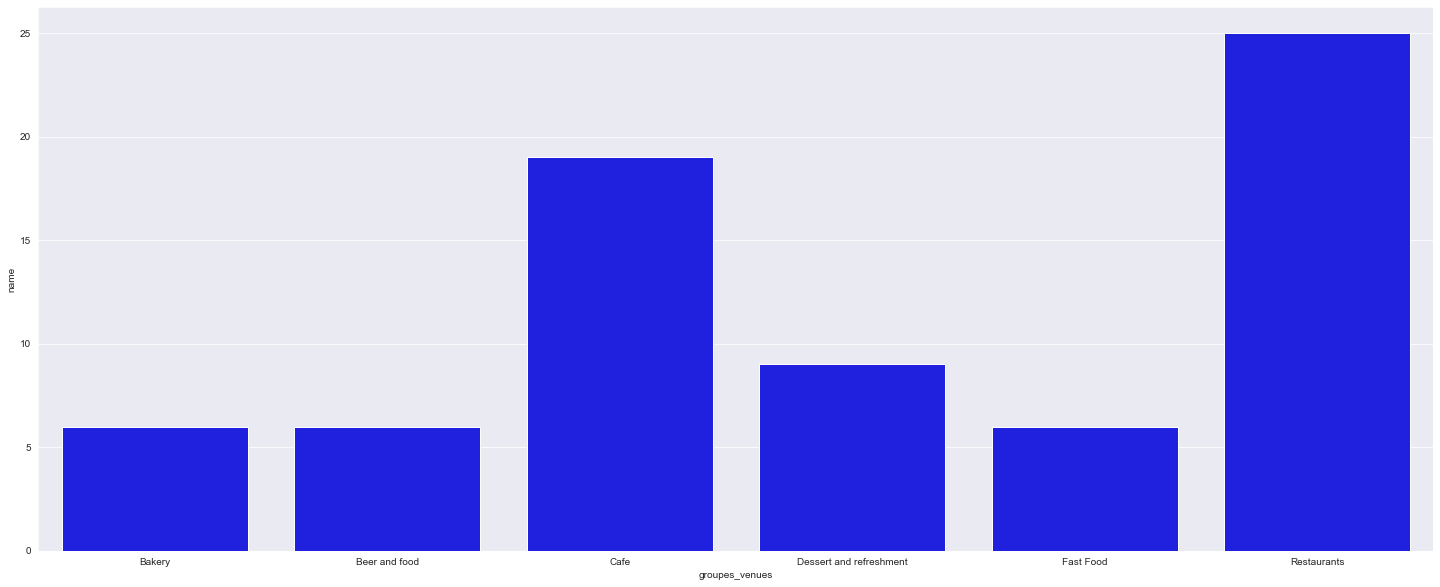

In [23]:
categories=filtred_venues.groupby(by='groupes_venues', as_index=False).count()['groupes_venues']
count_categories=filtred_venues.groupby(by='groupes_venues', as_index=False).count()['name']


plt.figure(figsize=(25, 10))
venues_grouped=sns.barplot(x=categories,y=count_categories,color='b')
plt.show()

<H3> <i> 2.2.2 DATA VISUALISATION : STATISTICAL ANALYSIS OF GROUPED TYPES OF VENUES BY MEAN OF LIKES </i> </H3>

<p style="text-align:justified;"></p>The count checking was followed by ploting of the likes values given each group. We can already assess that the overall likes of beer and food places, in addition to cafes are caracterised by good overall marks</p>

In [24]:
filtred_venues.groupby(by='groupes_venues', as_index=False).mean()[['groupes_venues','likes']]

,groupes_venues,likes
0,Bakery,41.333333
1,Beer and food,180.000000
2,Cafe,75.789474
3,Dessert and refreshment,36.777778
4,Fast Food,62.666667
5,Restaurants,39.880000


<Figure size 1800x720 with 0 Axes>

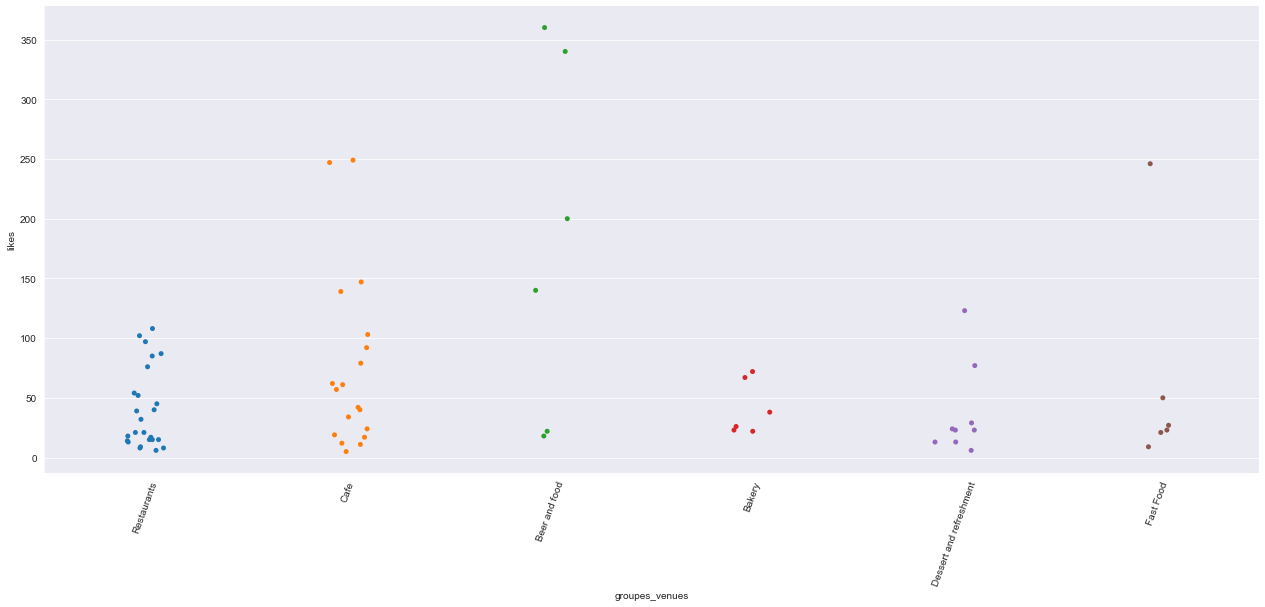

In [25]:
plt.figure(figsize=(25, 10))
categoriesplot=sns.catplot(x="groupes_venues", y="likes", data=filtred_venues,height=7,aspect=2.5)
categoriesplot.set_xticklabels(rotation=70)
plt.show()

<H3> <i> 2.2.3 DATA VISUALISATION : STATISTICAL ANALYSIS OF CUISINE TYPES FOR RESTAURANTS  BY COUNT </i> </H3>


<p style="text-align:justified;"></p>

<p style="text-align:justified;">Again, we tried to check the overall number of each type of cuisine to assess the overall dominance before hand . We now can clearly see that Italian food is dominant with a small margin </p>

In [26]:
filtred_venues_restaurants.groupby(by='types_cuisine', as_index=False).count().iloc[:,:2].T

,0,1,2,3,4,5,6,7,8,9,10,11
types_cuisine,American,Asian,French,General,Indian,Italian,Latino,Moroccan,Seafood,Spanish,Turkish,Vegan
name,3,3,3,1,1,4,1,3,2,2,1,1


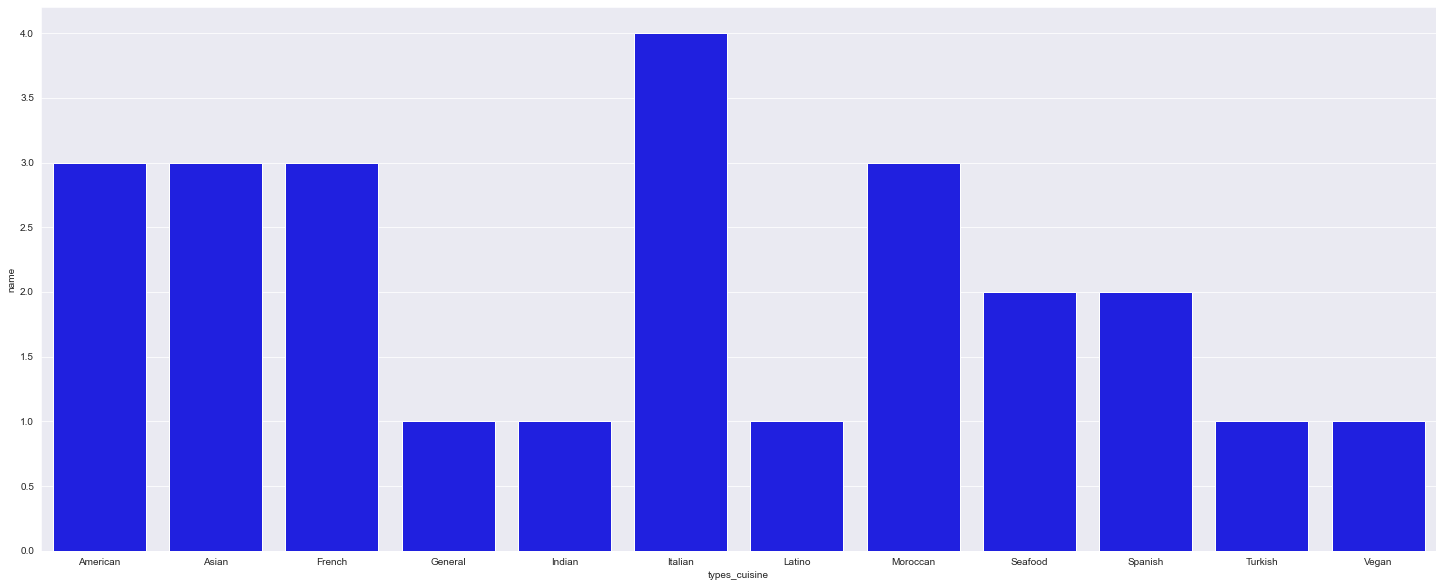

In [27]:
categories=filtred_venues_restaurants.groupby(by='types_cuisine', as_index=False).count()['types_cuisine']
count_categories=filtred_venues_restaurants.groupby(by='types_cuisine', as_index=False).count()['name']


plt.figure(figsize=(25, 10))
venues_grouped=sns.barplot(x=categories,y=count_categories,color='b')
plt.show()

<H3> <i> 2.2.4 DATA VISUALISATION : STATISTICAL ANALYSIS OF CUISINE TYPES FOR RESTAURANTS  BY MEAN OF LIKES </i> </H3>


<p style="text-align:justified;"></p>

<p style="text-align:justified;">We can clearly see now that Moroccan food get the most rating , followed by spannish  food and italian </p>

In [28]:
filtred_venues_restaurants.groupby(by='types_cuisine', as_index=False).mean()[['types_cuisine','likes']].T

,0,1,2,3,4,5,6,7,8,9,10,11
types_cuisine,American,Asian,French,General,Indian,Italian,Latino,Moroccan,Seafood,Spanish,Turkish,Vegan
likes,25.6667,27,45.3333,14,15,51,32,67.6667,46,57.5,15,13


<Figure size 1800x720 with 0 Axes>

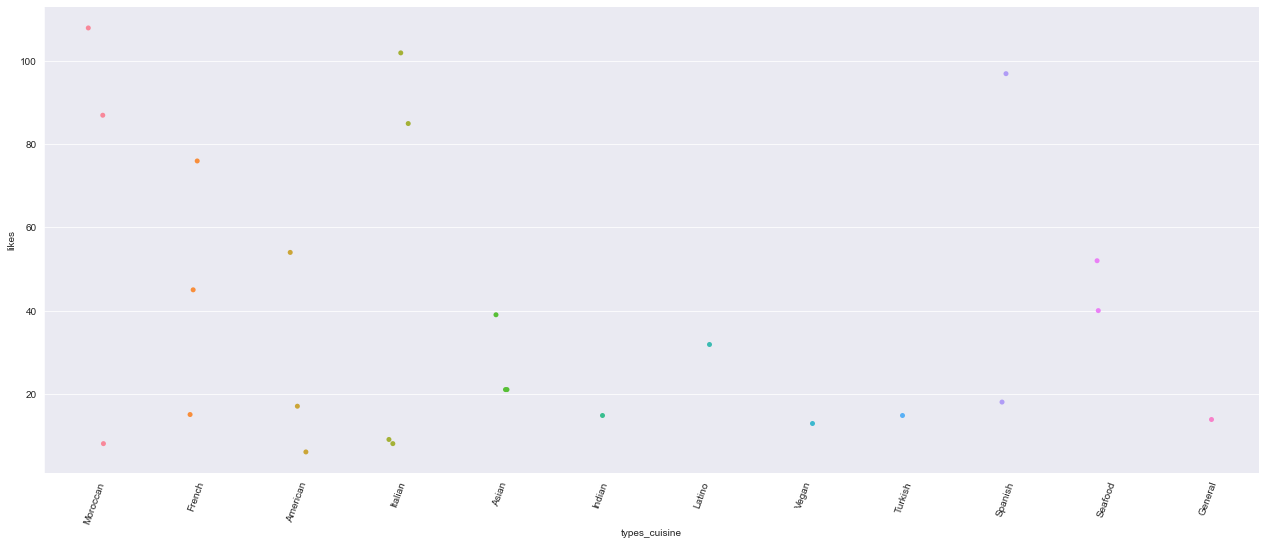

In [29]:
plt.figure(figsize=(25, 10))
categoriesplot=sns.catplot(x="types_cuisine", y="likes", data=filtred_venues_restaurants,height=7,aspect=2.5)
categoriesplot.set_xticklabels(rotation=70)
plt.show()

<H3> <i> 2.2.4 DATA VISUALISATION : MAPPING OF LOCATION</i> </H3>


<p style="text-align:justified;"></p>

<p style="text-align:justified;">Since we are working with geocoded data , it is important to account in the spatial aspect. We can clearly see visualy , the existence of tree main clusters, two of which are nearshore and another big one is centred in the city</p>

In [30]:
map_casa=folium.Map(location=[latitude, longitude], zoom_start=13)

types=['Restaurants','Cafe','Bakery','Beer and food','Dessert and refreshment','Fast Food']
colors_types=['blue','green','yellow','red','pink','black']

for ty,col in zip(types,colors_types):
    for lat, lng, label in zip(filtred_venues['lat'], filtred_venues['lng'], filtred_venues['groupes_venues'][filtred_venues['groupes_venues']=='{}'.format(ty)]):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='{}'.format(col),
            fill=True,
            fill_color='{}'.format(col),
            fill_opacity=0.7,
            parse_html=False).add_to(map_casa)

map_casa

<H1>  3 METHODOLOGY </H1>


<p style="text-align:justified;">
Visualizing data over hand gave us a good idea about what’s happening in the case of studied venues in the city of Casablanca. We can say already that restaurants and cofee are both dominant in terms of overall number which make them already interesting as choices
In the other hand, Beer places and coffee shops are the most positively rated if we talk groups of venues
    
As for the cuisines, Italian food prime in term of number. Moroccan food is better ratted, followed by Spanish and Italian food
Mapping of the location of all venues showed that three locations might be interesting already since we notice that all these venues cluster around each other Now what can be done? After preparing data for machine learning we will proceed by using doing a Pearson correlation study to choose which type / group is the best correlated with high likes. 
    
We will also need to conduct a clustering analysis to predict the best locations based on these data. The overall accuracy of multiple k values will be tested to choose the best value. This will be done for both cases of analysis: by group and by type if restaurants are chosen.
    
We expect that Pearson correlation will give us both most correlated type/group of venue with high likes. And clustering will give us the overall best location to place them. That’s if we assume that being near the successful targets would be a good idea.  To answer on this last supposition, we need more data that we don’t have for now: overall pricing, proximity to important other facilities </p>

<p style="text-align:justified;"> wE will need to prepare data for this task. Categories need to be one hot encoded and we will do that by using getdummies of pandas</p>


<H2> <i> 3.1 ONE HOT ENCODING OF CATEGORIES </i> </H2>

In [31]:

table_analysis_type_reg=pd.get_dummies(filtred_venues_restaurants[['types_cuisine']], prefix="", prefix_sep="")
table_analysis_type_reg['likes']=filtred_venues_restaurants['likes']


table_analysis_type=pd.get_dummies(filtred_venues_restaurants[['types_cuisine']], prefix="", prefix_sep="")
table_analysis_type['binnedlikes']=filtred_venues_restaurants['binnedlikes']



table_analysis_group=pd.get_dummies(filtred_venues[['groupes_venues']], prefix="", prefix_sep="")
table_analysis_group['binnedlikes']=filtred_venues['binnedlikes']


table_analysis_group_reg=pd.get_dummies(filtred_venues[['groupes_venues']], prefix="", prefix_sep="")
table_analysis_group_reg['likes']=filtred_venues['likes']

<H1>  4 RESULTS  </H1>

<H2> <i> 4.1 PEARSON CORRELATION </i> </H2>

<p style="text-align:justified;">The regression methods were not used for the simple reason that we cannot imagine predicting the existence of a like value based on the combination of inputs (venue type or groups) . 
    
This is because, the investor clearly stated that these groups and types need to be studied separately. 
    
Se what we did is calculating Pearson correlation for types and groups respectively. We concluded that Moroccan food is the most trending based on like because of the highest likes.
    
As for the groups, Beer and food are the most liked, followed by coffee shops.</p>


In [35]:
table_analysis_type_reg.corr()[['likes']].sort_values(by='likes',ascending=False).iloc[1:].T

,Moroccan,Spanish,Italian,French,Seafood,Latino,Asian,Indian,Turkish,American,General,Vegan
likes,0.313062,0.158526,0.148071,0.061441,0.055061,-0.049076,-0.145114,-0.154949,-0.154949,-0.160136,-0.161177,-0.167405


In [36]:
table_analysis_group_reg.corr()[['likes']].sort_values(by='likes',ascending=False).iloc[1:].T

,Beer and food,Cafe,Fast Food,Bakery,Dessert and refreshment,Restaurants
likes,0.474739,0.103348,-0.001295,-0.087847,-0.13334,-0.227464


<H2> <i>4.2 KNN clustering </i> </H2>

<p style="text-align:justified;">For this task we proceeded by locating the clusters that are detected from data.  We done this process for the two types of prepared tables.
    
For this step we used the binned likes for clustering.
For testing the method, we used the train-test-split method. We choose 40% of data for testing and left 60% for training. We used the accuracy method and by running this calculation we found the best values of clusters for each scenario
 
    
This process was first done to the types of restaurants. This work showed that we need to used 3 clusters for an estimated accuracy of 50%.
    
The evaluation of the likes obtained for each cluster showed that the cluster number 0 is the one characterized by the best values in term of likes. 
    
As for their geolocation, we notice two main important places (cluster 0 in red) . Both are either in the center or in the top north of the area.
</p>





D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

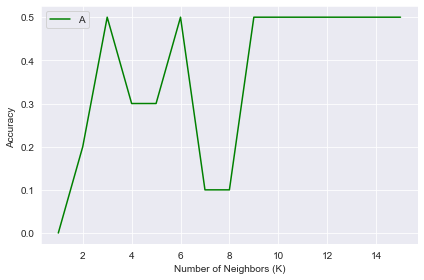

The best accuracy is 0.5 with k= 3


In [40]:

X=table_analysis_type.iloc[:,:-1]
y=table_analysis_type[['binnedlikes']]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


K = 16
mean_acc = np.zeros((K-1))


for i in range(1,K):
    
    fit = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    pred=fit.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, pred)


plt.plot(range(1,K),mean_acc,'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy is", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [41]:
kclusters = 3



kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
kmeans_result=pd.DataFrame(kmeans.labels_)
filtred_venues['cluster_results']=kmeans_result

clustertable=filtred_venues.copy()
clustertable.dropna(inplace=True)
clustertable['cluster_results']=clustertable['cluster_results'].astype(int)

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


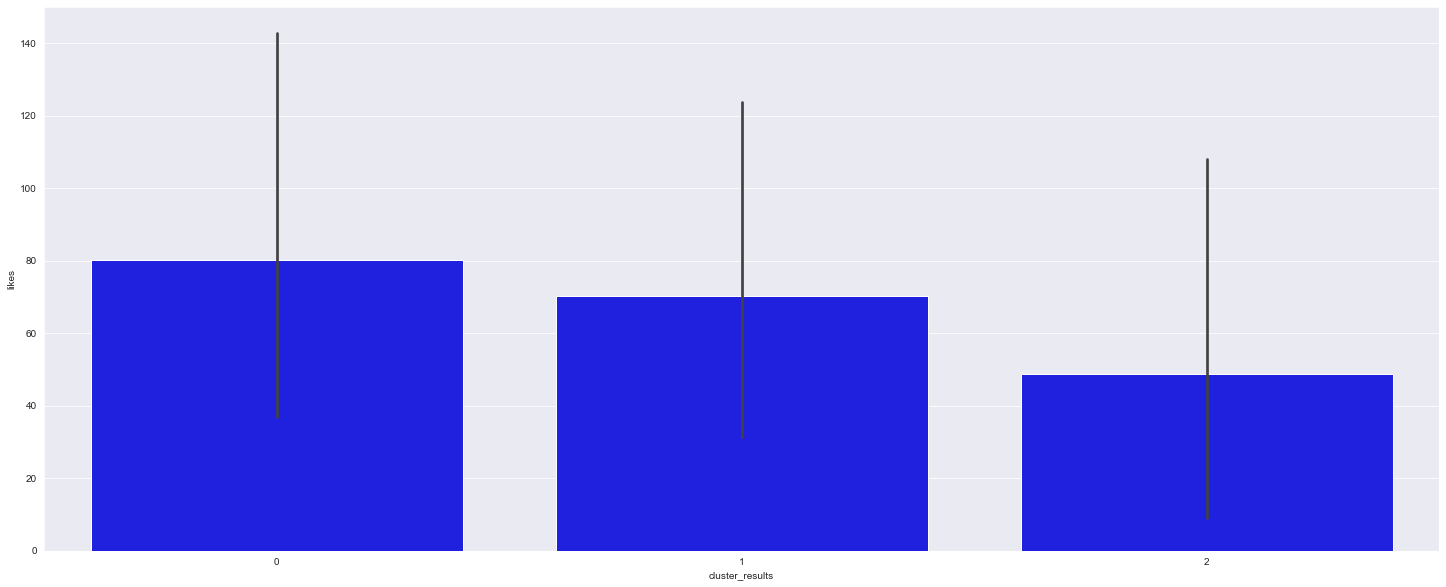

In [42]:
plt.figure(figsize=(25, 10))
venues_grouped=sns.barplot(x=clustertable['cluster_results'],y=clustertable['likes'],color='b')
plt.show()

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(filtred_venues['lat'], clustertable['lng'], clustertable['groupes_venues'], clustertable['cluster_results']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<p style="text-align:justified;">The second process was done to the groups of venues. This work showed that we need to used 3 clusters again for an estimated accuracy of 31%.
    
    
The evaluation of the likes obtained for each cluster showed that the cluster number 1 is the one characterized by the best values in term of likes. 
    
    
As for their geolocation, we notice two main important places (cluster 1 in purple) . Both are either in the center or in the top north of the area. These results surimpose with the precendent ones obtained for the types of restaurants.</p>


D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

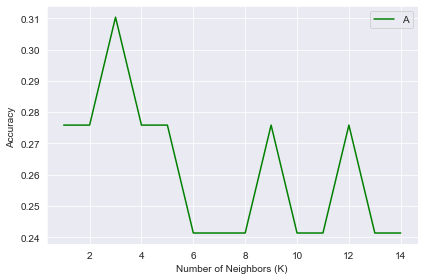

The best accuracy is 0.3103448275862069 with k= 3


In [50]:

X=table_analysis_group.iloc[:,:-1]
y=table_analysis_group[['binnedlikes']]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


K = 15
mean_acc = np.zeros((K-1))


for i in range(1,K):
    
    fit = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    pred=fit.predict(X_test)
    mean_acc[i-1] = metrics.accuracy_score(y_test, pred)


plt.plot(range(1,K),mean_acc,'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy is", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [51]:
kclusters = 3



kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
kmeans_result=pd.DataFrame(kmeans.labels_)
filtred_venues['cluster_results']=kmeans_result

clustertable=filtred_venues.copy()
clustertable.dropna(inplace=True)
clustertable['cluster_results']=clustertable['cluster_results'].astype(int)

D:\WORK\PYTHON\envs\PYTHON36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(filtred_venues['lat'], clustertable['lng'], clustertable['groupes_venues'], clustertable['cluster_results']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

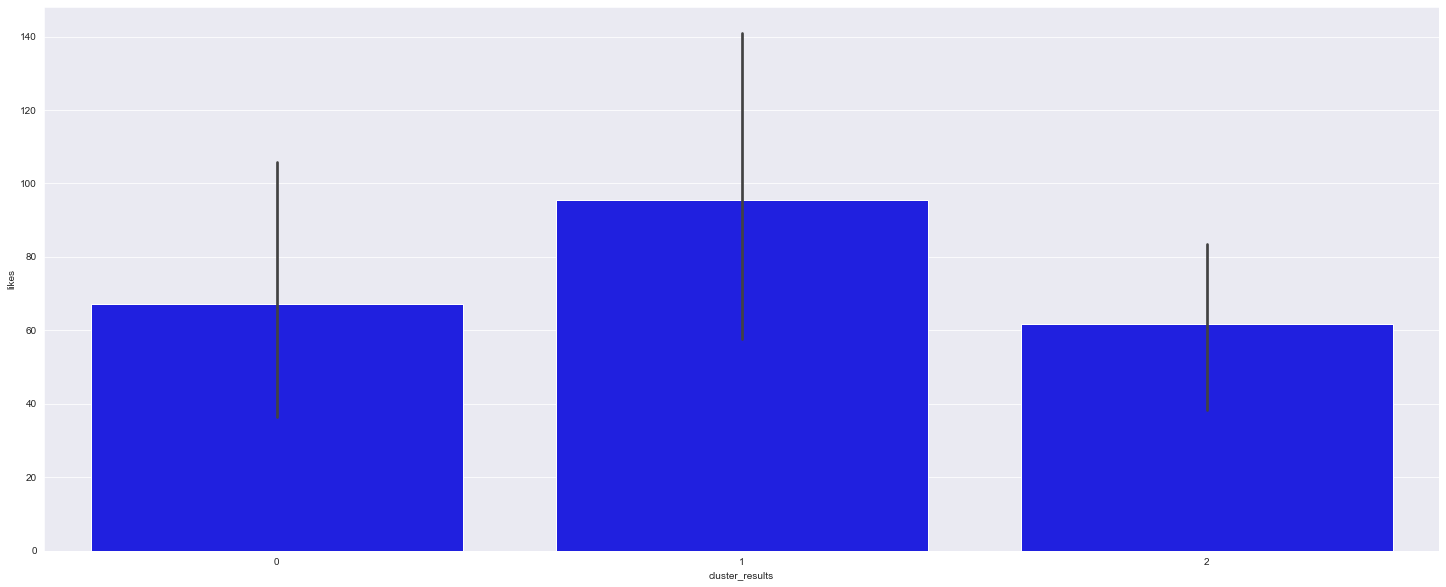

In [53]:
plt.figure(figsize=(25, 10))
venues_grouped=sns.barplot(x=clustertable['cluster_results'],y=clustertable['likes'],color='b')
plt.show()

<H1>  5 Discussion  </H1>

<p style="text-align:justified;">We notice that both the north and the center part of the city were highlighted twice in our clustering analysis. The clusters in those two locations are described by high values of mean likes.
    
We could suppose that these two places are interesting to open shop. because they both show overall high likes compared to every other place.
    
Now if we want to talk about the most interesting of venues that could be chosen, we could say that since Pearson correlation states that Moroccan food is more correlated with high likes, we can recommend that we open shop for this type of food . We can also add to the least beer & food venues, followed by cofee shops. 
    
  
Knowing this we can say that we have obtained some results that could be presented as a conclusion and recommendation for the investor.
</p>


<H1>  6	Conclusion  </H1>

<p style="text-align:justified;">We conclude that opening shop for Moroccan food is the best choice in term of overall likes correlation if the investor which to open a restaurant.
    
If it’s the case of decision for the best venues overall, beer& food, followed by coffee shops are the best, followed by restaurants. The choice for these groups might be already done based on the available money to invest.
    
As for the location, we suppose that the top north and central part of the city are quite interesting, owing to the overall likes.

</p>
